# Using the PatentsView API to pull data about design patents granted by the USPTO applied for from 1980-2015

Associated data fields:
1. patent number
2. application data
3. USPC class at the subclass level

In [2]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.debugger import set_trace


In [2]:
def remove_non_design(df):
    #filter to make sure mis-classified patents are not included
    return df[df.patent_number.str.contains('D')]
    

In [3]:
def extract_date(df):
    keep = df.copy()
    #extract application date and year
    keep['app_date'] = keep['applications'].astype(str).str.extract('(\d{4}-\d{2}-\d{2})')
#     set_trace()
    pd.to_datetime(keep.app_date, errors='coerce')
    keep.drop('applications', axis=1, inplace=True)
    
    keep['app_date'] = pd.to_datetime(keep['app_date'], errors='coerce')
    keep['year'] =keep['app_date'].apply(lambda x: x.year)
    return keep

In [4]:
def extract_class(df):
    keep = df.copy()
    #extract class information
    pattern = "([D0-9]\d{2}/\d{1,3}\.?\d{1,2})"

    keep['uspcs'] = keep['uspcs'].astype(str).str.findall(pattern)
    holder = keep.apply(lambda x: pd.Series(x['uspcs']),axis=1).stack().reset_index(level=1, drop=True)
    holder.name = 'class'
    return keep.drop('uspcs', axis=1).join(holder)

In [5]:
def mark_missing_citaitons(df):
    
    """ Marks patents that have missing citaiton data
        
        Args:
        df(dataframe): the datafame to be cleaned
        
        Returns:
        df(dataframe): the proccessed dataframe with additional columns is_missing(boolean) and num_missing(int)
    """
    
    keep = df.copy()

    keep['num_cited_returned'] = keep['cited_patents'].astype(str).str.findall('(\d{7}|D\d{6})').apply(lambda x: len(x))
    keep['patent_num_us_patent_citations'] = keep['patent_num_us_patent_citations'].astype(np.int64)
    keep['num_missing'] = keep['patent_num_us_patent_citations'].sub(keep['num_cited_returned'])
    keep['is_missing'] = np.where(keep['num_missing'] >0, 1, 0)
    
    return keep
    

In [3]:
# building the query dynamically
base_url = "http://www.patentsview.org/api/patents/query?"
field_list = "&f=[\"patent_number\",\"app_date\",\"uspc_subclass_id\",\"cited_patent_number\",\"patent_num_us_patent_citations\"]"

master_df = pd.DataFrame()

In [7]:
#Due to the limits of the amount of results the API can return, query must be performed in loop by date and page

for year in range(1980,2016):
    page = 1
    more_patents = True
    
    while more_patents:
        
        query = "q={{\"_and\":[{{\"patent_type\":\"Design\"}},{{\"_gte\":{{\"app_date\":\"{0}-01-01\"}}}},{{\"_lte\":{{\"app_date\":\"{0}-12-31\"}}}}]}}".format(year)
        options = "&o={{\"per_page\":10000,\"page\":{}}}".format(page)

        full_url = base_url + query + field_list + options
        r = requests.get(full_url)
        print(r)
        data = r.json()
        print(year,"-",page,"-",data['count'])

        
        df = pd.io.json.json_normalize(data['patents'])
        master_df = pd.concat([master_df, df], ignore_index=True)

        
        # decide if to continue to next year or next page
        if data['count'] < 10000:
            more_patents = False
        else:
            page += 1
            
      


<Response [200]>
1980 - 1 - 5034
<Response [200]>
1981 - 1 - 4807
<Response [200]>
1982 - 1 - 5216
<Response [200]>
1983 - 1 - 5495
<Response [200]>
1984 - 1 - 6020
<Response [200]>
1985 - 1 - 6506
<Response [200]>
1986 - 1 - 6337
<Response [200]>
1987 - 1 - 6950
<Response [200]>
1988 - 1 - 7409
<Response [200]>
1989 - 1 - 7581
<Response [200]>
1990 - 1 - 8388
<Response [200]>
1991 - 1 - 8533
<Response [200]>
1992 - 1 - 8722
<Response [200]>
1993 - 1 - 9296
<Response [200]>
1994 - 1 - 10000
<Response [200]>
1994 - 2 - 932
<Response [200]>
1995 - 1 - 10000
<Response [200]>
1995 - 2 - 1779
<Response [200]>
1996 - 1 - 10000
<Response [200]>
1996 - 2 - 2402
<Response [200]>
1997 - 1 - 10000
<Response [200]>
1997 - 2 - 3494
<Response [200]>
1998 - 1 - 10000
<Response [200]>
1998 - 2 - 4274
<Response [200]>
1999 - 1 - 10000
<Response [200]>
1999 - 2 - 4990
<Response [200]>
2000 - 1 - 10000
<Response [200]>
2000 - 2 - 5837
<Response [200]>
2001 - 1 - 10000
<Response [200]>
2001 - 2 - 5589
<Re

In [8]:
master_df.sample(5)

,applications,cited_patents,patent_num_us_patent_citations,patent_number,uspcs
92493,"[{'app_date': '1993-05-12', 'app_id': '29/0082...","[{'cited_patent_number': None}, {'cited_patent...",9,D356713,"[{'uspc_subclass_id': 'D07/306'}, {'uspc_subcl..."
220765,"[{'app_date': '2002-12-19', 'app_id': '29/1728...","[{'cited_patent_number': 'D421918'}, {'cited_p...",6,D490325,[{'uspc_subclass_id': 'D10/39'}]
116229,"[{'app_date': '1995-09-12', 'app_id': '29/0438...","[{'cited_patent_number': 'D328827'}, {'cited_p...",13,D381825,"[{'uspc_subclass_id': 'D06/369'}, {'uspc_subcl..."
247554,"[{'app_date': '2004-10-26', 'app_id': '29/2158...","[{'cited_patent_number': None}, {'cited_patent...",9,D509550,[{'uspc_subclass_id': 'D21/713'}]
436343,"[{'app_date': '2012-10-23', 'app_id': '29/4353...","[{'cited_patent_number': '5694292'}, {'cited_p...",38,D710841,[{'uspc_subclass_id': 'D14/318'}]


In [16]:
master_df = remove_non_design(master_df)

In [9]:
master_df.to_csv('designDirty')

In [19]:
master_df = extract_date(master_df)

/home/tiera/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


In [20]:
master_df.head()

,cited_patents,patent_num_us_patent_citations,patent_number,uspcs,app_date,year
0,"[{'cited_patent_number': None}, {'cited_patent...",5,D257752,[{'uspc_subclass_id': 'D19/75'}],1980-01-14,1980
1,"[{'cited_patent_number': None}, {'cited_patent...",5,D257924,[{'uspc_subclass_id': 'D06/573'}],1980-01-14,1980
2,"[{'cited_patent_number': None}, {'cited_patent...",10,D258382,[{'uspc_subclass_id': 'D23/214'}],1980-01-17,1980
3,"[{'cited_patent_number': None}, {'cited_patent...",10,D258383,[{'uspc_subclass_id': 'D23/214'}],1980-01-17,1980
4,[{'cited_patent_number': None}],4,D258571,[{'uspc_subclass_id': 'D09/560'}],1980-04-03,1980


How has design patent activity changed over time?

In [26]:
by_year = master_df.set_index('patent_number')

In [27]:
by_year.head()

,cited_patents,patent_num_us_patent_citations,uspcs,app_date,year
patent_number,,,,,
D257752,"[{'cited_patent_number': None}, {'cited_patent...",5,[{'uspc_subclass_id': 'D19/75'}],1980-01-14,1980
D257924,"[{'cited_patent_number': None}, {'cited_patent...",5,[{'uspc_subclass_id': 'D06/573'}],1980-01-14,1980
D258382,"[{'cited_patent_number': None}, {'cited_patent...",10,[{'uspc_subclass_id': 'D23/214'}],1980-01-17,1980
D258383,"[{'cited_patent_number': None}, {'cited_patent...",10,[{'uspc_subclass_id': 'D23/214'}],1980-01-17,1980
D258571,[{'cited_patent_number': None}],4,[{'uspc_subclass_id': 'D09/560'}],1980-04-03,1980


In [31]:
by_year = by_year[['uspcs', 'year']]

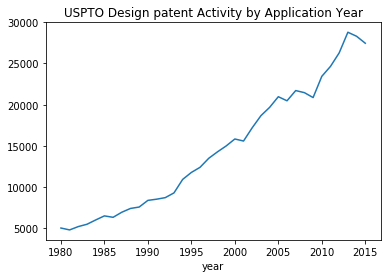

In [46]:
by_year.groupby('year').agg('count').plot(kind='line', legend=False, title="USPTO Design patent Activity by Application Year")

What percentage of all patent applications are design patents?

In [4]:
utility_df = pd.DataFrame()
field_list = "&f=[\"patent_number\",\"app_date\"]"

In [11]:
#Due to the limits of the amount of results the API can return, query must be performed in loop by date and page

for year in range(1993,2016):
    page = 1
    more_patents = True
    
    while more_patents:
        
        query = "q={{\"_and\":[{{\"patent_type\":\"Utility\"}},{{\"_gte\":{{\"app_date\":\"{0}-01-01\"}}}},{{\"_lte\":{{\"app_date\":\"{0}-12-31\"}}}}]}}".format(year)
        options = "&o={{\"per_page\":10000,\"page\":{}}}".format(page)

        full_url = base_url + query + field_list + options
        r = requests.get(full_url)
        print(r)
        data = r.json()
        print(year,"-",page,"-",data['count'])

        
        df = pd.io.json.json_normalize(data['patents'])
        utility_df = pd.concat([master_df, df], ignore_index=True)

        
        # decide if to continue to next year or next page
        if data['count'] < 10000:
            more_patents = False
        else:
            page += 1
            
      


<Response [200]>
1993 - 1 - 10000
<Response [200]>
1993 - 2 - 10000
<Response [200]>
1993 - 3 - 10000
<Response [200]>
1993 - 4 - 10000
<Response [200]>
1993 - 5 - 10000
<Response [200]>
1993 - 6 - 10000
<Response [200]>
1993 - 7 - 10000
<Response [200]>
1993 - 8 - 10000
<Response [200]>
1993 - 9 - 10000
<Response [200]>
1993 - 10 - 10000
<Response [200]>
1993 - 11 - 0


TypeError: 'NoneType' object is not subscriptable

In [ ]:
utility_df.tail()

In [11]:
classes = extract_date(master_df)

/home/tiera/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


In [12]:
classes = extract_class(classes)

In [13]:
classes.drop(columns = ['cited_patents','patent_num_us_patent_citations','app_date'], inplace=True)

In [14]:
classes.head()

,patent_number,year,class
0,D257752,1980,D19/75
1,D257924,1980,D06/573
2,D258382,1980,D23/214
3,D258383,1980,D23/214
4,D258571,1980,D09/560


# How much citation data is missing?

In [10]:
# # master_df = remove_non_design(master_df)
# # master_df = extract_date(master_df)
# # master_df = extract_class(master_df)
# missing = mark_missing_citaitons(master_df)

In [11]:
# missing.head()

,applications,cited_patents,patent_num_us_patent_citations,patent_number,uspcs,num_cited_returned,num_missing,is_missing
0,"[{'app_date': '1980-01-14', 'app_id': '06/1118...","[{'cited_patent_number': None}, {'cited_patent...",5,D257752,[{'uspc_subclass_id': 'D19/75'}],1,4,1
1,"[{'app_date': '1980-01-14', 'app_id': '06/1118...","[{'cited_patent_number': None}, {'cited_patent...",5,D257924,[{'uspc_subclass_id': 'D06/573'}],1,4,1
2,"[{'app_date': '1980-01-17', 'app_id': '06/1130...","[{'cited_patent_number': None}, {'cited_patent...",10,D258382,[{'uspc_subclass_id': 'D23/214'}],1,9,1
3,"[{'app_date': '1980-01-17', 'app_id': '06/1130...","[{'cited_patent_number': None}, {'cited_patent...",10,D258383,[{'uspc_subclass_id': 'D23/214'}],1,9,1
4,"[{'app_date': '1980-04-03', 'app_id': '06/1368...",[{'cited_patent_number': None}],4,D258571,[{'uspc_subclass_id': 'D09/560'}],0,4,1


In [11]:
# missing.shape

(525490, 8)

In [ ]:

# (missing[missing['num_missing'] >0].shape[0]/master_df.shape[0]) *100

Approx 54.926% of citation data is missing. This is mostly due to citing patents that were granted before 1976, which is the yeat that patentViews beings coverage.

Let's break it down by year

In [ ]:

# master_df.groupby(['year']).apply((lambda x: (x[x['num_missing'] > 0].shape[0]/ x.shape[0])*100)).plot(title="Percent of Patents with missing Citation Data")

In [ ]:
# master_df['test'] = master_df['cited_patents'].astype(str).str.findall(pattern)

In [12]:
# missing.drop(columns=['applications','patent_num_us_patent_citations','uspcs','num_cited_returned','num_missing'], inplace=True)

In [13]:
# pattern = "([D0-9]\d{6})"

In [14]:
# missing['cited_patents'] = missing['cited_patents'].astype(str).str.findall(pattern)

In [ ]:
# holder = missing.apply(lambda x: pd.Series(x['cited_patents']),axis=1).stack().reset_index(level=1, drop=True)

In [ ]:
# holder.name = 'class'

In [ ]:
# missing.drop('cited_patents', axis=1).join(holder)